# Arbol de decision
En este notebook vamos a entrenar y explorar un arbol de decision.
Podemos encontrar la documentacion del modelo en:  
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier

In [20]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, tree
from ipywidgets import Button, IntSlider, interactive

from preprocessing import cargarDatasets
from preprocessing import prepararSet
from preprocessing import ingenieriaDeFeaturesArboles1
from preprocessing import ingenieriaDeFeaturesArboles2

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import train_test_split,GridSearchCV

## Carga y preprocesamiento de los datos
Cargamos los datasets y los preparamos para usar.

In [21]:
train_df,final_df = cargarDatasets()
train_df = prepararSet(train_df)

In [22]:
X,y,df,y_encoder = ingenieriaDeFeaturesArboles1(train_df)
X_reducido,y_reducido,df_reducido,y_encoder_reducido = ingenieriaDeFeaturesArboles2(train_df)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=117, test_size=0.1, stratify=y)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reducido, y_reducido, random_state=117, test_size=0.1, stratify=y_reducido)

Los principales hiperarametros son:  
* max_depth: la profundidad maxima del arbol. Si resulta ser muy profundo, puede overfittear.
* min_samples_leaf: cantidad minima de muestras en cada hoja. Si este numero es relativamente chico, tambien puede overfittear.
* criterion: puede usarse el criterio de gini o el de information gain. Se utiliza para elegir el mejor feature para cada hoja.

In [4]:
params = {'max_depth': np.arange(1, 10),'min_samples_leaf': np.arange(20,30),
          "criterion": ["gini", "entropy"]}

In [5]:
arbol = tree.DecisionTreeClassifier()
arbol_r = tree.DecisionTreeClassifier()

In [6]:
gscv = GridSearchCV(
    arbol, params, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train, y_train)

print(f"Best score: {gscv.best_score_}")
print(f"Best params {gscv.best_params_}")

Best score: 0.9010846930997207
Best params {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 20}


Obtenemos:  
Best score: 0.9010804911090377  
Best params {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 20}

In [7]:
gscv_r = GridSearchCV(
    arbol_r, params, scoring='accuracy', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train_r, y_train_r)

print(f"Best score: {gscv_r.best_score_}")
print(f"Best params {gscv_r.best_params_}")

Best score: 0.8532281821236344
Best params {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 21}


Para este modelo obtenemos:  
Best score: 0.8532281821236344  
Best params {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 21}  

Como obtuvimos un mejor roc score con el primer arbol, nos quedamos con este para predecir y medir las metricas.

In [23]:
params = {'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 20}

arbol.set_params(**params)
arbol.fit(X_train, y_train)
y_pred = arbol.predict(X_test)

## Evaluacion de metricas
Las metricas a utilizar son:
* AUC-ROC  
* Matriz de confusión  
* Accuracy  
* Precisión  
* Recall  

Observamos las metricas obtenidas de las predicciones con el set de prueba.

In [9]:
from sklearn.metrics import classification_report

print(classification_report(y_test, arbol.predict(X_test)))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91      2473
           1       0.74      0.59      0.66       784

    accuracy                           0.85      3257
   macro avg       0.81      0.76      0.78      3257
weighted avg       0.84      0.85      0.85      3257



### Curva AUC ROC
Primero calculamos el score obtenido con la curva de AUC ROC.

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, plot_roc_curve

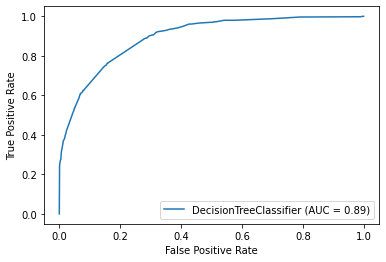

In [11]:
plot_roc_curve(arbol,X_test,y_test,response_method='predict_proba')
plt.show()

Podemos ver que la curva de auc roc nos indica que es mas probable que predigamos la clase de manera correcta.

### Matriz de confusion

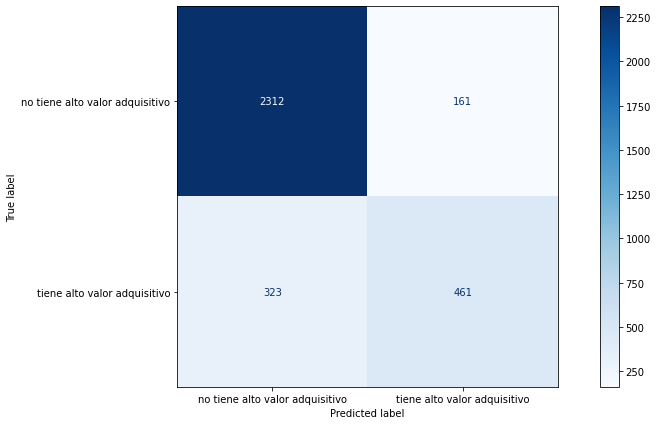

In [19]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(15, 7))
plt.grid(False)
plot_confusion_matrix(
    arbol, X_test, y_test, cmap=plt.cm.Blues, display_labels=['no tiene alto valor adquisitivo', 'tiene alto valor adquisitivo'], ax=ax
)
plt.show()

### Accuracy

In [13]:
accuracy_score(y_test, y_pred) 

0.8513969910961007

### Precision

In [14]:
precision_score(y_test, y_pred)

0.7411575562700965

### Recall

In [15]:
recall_score(y_test, y_pred)

0.5880102040816326

## Visualizacion del arbol obtenido

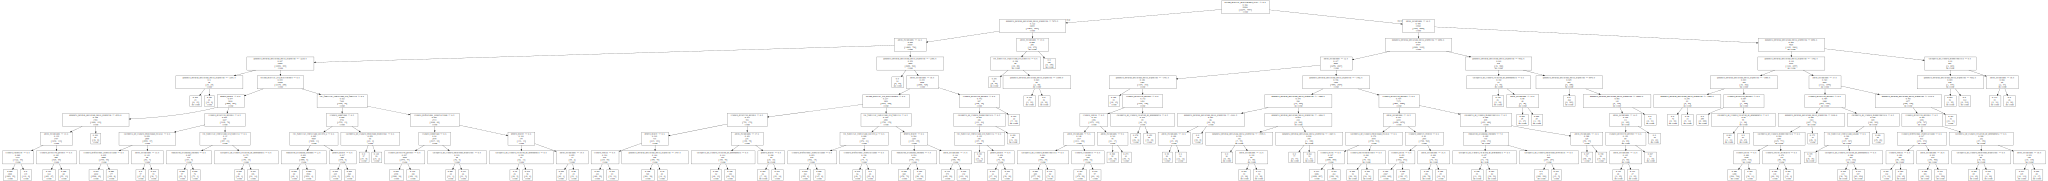

In [16]:
from sklearn.tree import export_graphviz
import graphviz
from pydotplus import graph_from_dot_data

feature_names = X_train.columns

feature_names
dot_data = export_graphviz(arbol, feature_names=feature_names, label = all, class_names=["tiene", "no tiene"])

graph = graphviz.Source(dot_data, format='png')
graph

## Prediccion sobre el data set de hold out

In [24]:
from preprocessing import prepararSetDeHoldOutArbol

In [25]:
aux = final_df.copy()

final_df_copy = prepararSetDeHoldOutArbol(final_df)

ho_prediction = arbol.predict(final_df_copy)
aux['tiene_alto_valor_adquisitivo'] = ho_prediction

aux.to_csv('predicciones/arbolDeDecision.csv')